# SCARF: Self-Supervised Contrastive Learning using Random Feature Corruption

![image](SCARF_Schema.png)

This file contains an implementation of SCARF on a publicly available [Darwin dataset](https://archive.ics.uci.edu/dataset/732/darwin). 
The dataset contains 451 features across 174 participants with 2 classes: Alzheimer's disease patients or healthy.
The goal is to  learn a tabular data representation in an unsupervised or self-supervised such that the learnt representations can be good at the classification task.

Adapted from [pytorch implementation of SCARF](https://github.com/clabrugere/pytorch-scarf/tree/master).

In [52]:
# importing packages
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import random
import os
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix)
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm
from scarf import scarf_model, loss
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
# check the current directory, set it as scarf
if os.getcwd()!= '/home/trips/ContrastiveLearning_Tutorial/scarf':  # replace the path with your local path
    os.chdir('/home/trips/ContrastiveLearning_Tutorial/scarf')
print("Current working directory is : ", os.getcwd())

Current working directory is :  /home/trips/ContrastiveLearning_Tutorial/scarf


In [12]:
# function for initial loading and processing of the dataset
def load_dataset(dataset):
    data_file = os.path.join('../Small_datasets', dataset, dataset + ".csv")
    df = pd.read_csv(data_file)
    
    # convert the target into numeric
    df.loc[df['class']=='P','class']=1
    df.loc[df['class']=='H','class']=0
    
    df['class'] = df['class'].astype(int)
    df['class'] = df['class'].astype(int)
    
    data, target = df.iloc[:,1:], df.iloc[:,-1]  # first column is the id and last column is the target


    train_data, test_data, train_target, test_target = train_test_split(
        data, 
        target, 
        test_size=0.2, 
        stratify=target, 
        random_state=seed
    )

    # preprocess
    constant_cols = [c for c in train_data.columns if train_data[c].nunique() == 1]
    train_data.drop(columns=constant_cols, inplace=True)
    test_data.drop(columns=constant_cols, inplace=True)

    scaler = StandardScaler()
    train_data = pd.DataFrame(scaler.fit_transform(train_data), columns=train_data.columns)
    test_data = pd.DataFrame(scaler.transform(test_data), columns=test_data.columns)

    # to torch dataset
    train_ds = scarf_model.ExampleDataset(
        train_data.to_numpy(), 
        train_target.to_numpy(), 
        columns=train_data.columns
    )
    test_ds = scarf_model.ExampleDataset(
        test_data.to_numpy(), 
        test_data.to_numpy(), 
        columns=test_data.columns
    )

#     print(f"Train set: {train_ds.shape}")
#     print(f"Test set: {test_ds.shape}")
    train_ds.to_dataframe().head()

    return train_data, train_ds, train_target,test_data, test_ds, test_target
    

In [73]:
# initial setting and the dataset choice

dataset = "Darwin" # dataset name
batch_size=128
epochs = 1000
lr=0.001  # learning rate
repr_dims= 100  # representation dimension
seed = 100  # random seed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
corruptionRate = 0.6

In [74]:
# loading data, orig_tr and orig_te is the form without anchor etc
orig_tr, train_data, train_labels,orig_te, test_data, test_labels = load_dataset(dataset)

# data dimensions 
print(" Training data size :  ", train_data.shape)  # Number of samples *  number of features
print(" Test data size :  ", test_data.shape)
print(" Class prevalence : ", (train_labels.sum() + test_labels.sum() )/(train_data.shape[0] +test_data.shape[0]) )

 Training data size :   (139, 451)
 Test data size :   (35, 451)
 Class prevalence :  0.5114942528735632


In [75]:
# Setting up the data laoder and initializing the models
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = scarf_model.SCARF(
    input_dim=train_data.shape[1], 
    emb_dim=repr_dims,
    corruption_rate=corruptionRate,
).to(device)
optimizer = Adam(model.parameters(), lr=lr)
ntxent_loss = loss.NTXent()

In [76]:
# fitting the model
loss_history = []

for epoch in range(1, epochs + 1):
    epoch_loss = scarf_model.train_epoch(model, ntxent_loss, train_loader, optimizer, device, epoch)
    loss_history.append(epoch_loss)

Text(0, 0.5, 'loss')

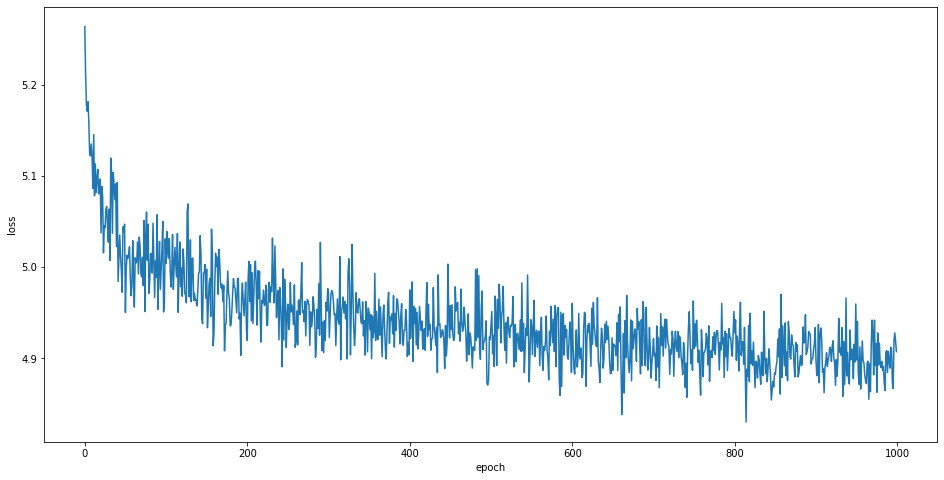

In [77]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(loss_history)
ax.set_xlabel("epoch")
ax.set_ylabel("loss")

In [78]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# get embeddings for training and test set
train_embeddings = scarf_model.dataset_embeddings(model, train_loader, device)
test_embeddings = scarf_model.dataset_embeddings(model, test_loader, device)

print(train_embeddings.shape)
print(test_embeddings.shape)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 628.17it/s]

(139, 100)
(35, 100)


## Visualize the embeddings using t-sne

/home/trips/Virtual_env_python/lib64/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Text(0.5, 1.0, 'Dataset : Darwin \n tsne reduced representation of time series')

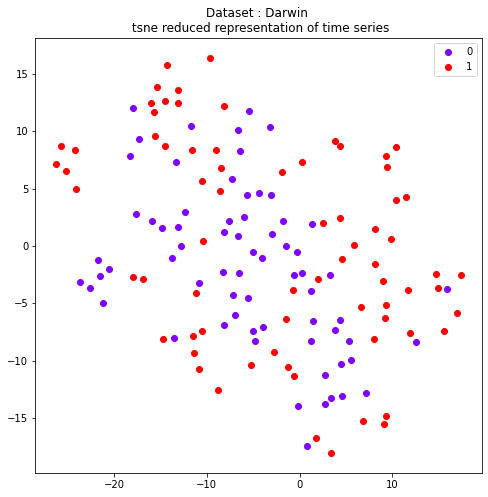

In [79]:
tsne = TSNE(n_components=2, learning_rate="auto", init="pca", perplexity=15)
reduced = tsne.fit_transform(train_embeddings)

# obtaining unique labels
unique_labels = np.unique(train_labels)

fig, ax = plt.subplots(figsize=(8, 8))

colors = cm.rainbow(np.linspace(0, 1, len(unique_labels)))

for label, col in zip(unique_labels, colors):
    indices = [i for i, l in enumerate(train_labels) if l == label]
    
    current_tx = np.take(reduced[:,0], indices)
    current_ty = np.take(reduced[:,1], indices)
    
    ax.scatter(current_tx, current_ty, color=col, label=label)
    
# build a legend using the labels we set previously
plt.legend(loc='best')
plt.title("Dataset : "+dataset +" \n tsne reduced representation of time series")

## Linear evaluation

In [80]:
# on the original dataset
clf = LogisticRegression()

# vanilla dataset: train the classifier on the original data
clf.fit(orig_tr, train_labels)
vanilla_predictions = clf.predict(orig_te)

#
y_score = clf.predict_proba(orig_te)
auprc = average_precision_score(test_labels, y_score[:,1])
auroc = roc_auc_score(test_labels, y_score[:,1])

print("Dataset : ", dataset, " performance on the original data with a LR classifier" )
print(" Accuracy : ", clf.score(orig_te, test_labels))
print('AUROC: ', auroc)
print('AUPRC: ', auprc) 

Dataset :  Darwin  performance on the original data with a LR classifier
 Accuracy :  0.8571428571428571
AUROC:  0.8888888888888888
AUPRC:  0.8044637007872303


In [81]:
# RF classifier 
clf_rf = RandomForestClassifier(max_depth=2, random_state=0)
clf_rf.fit(orig_tr, train_labels)

y_score = clf_rf.predict_proba(orig_te)
auprc = average_precision_score(test_labels, y_score[:,1])
auroc = roc_auc_score(test_labels, y_score[:,1])

print("Dataset : ", dataset, " performance on the original data with a RF classifier" )
print(" Accuracy : ", clf_rf.score(orig_te, test_labels))
print('AUROC: ', auroc)
print('AUPRC: ', auprc) 

Dataset :  Darwin  performance on the original data with a RF classifier
 Accuracy :  0.9714285714285714
AUROC:  1.0
AUPRC:  1.0


In [82]:
# on the learnt embeddings

clf = LogisticRegression()

# vanilla dataset: train the classifier on the original data
clf.fit(train_embeddings, train_labels.values)
vanilla_predictions = clf.predict(test_embeddings)

y_score = clf.predict_proba(test_embeddings)
auprc = average_precision_score(test_labels, y_score[:,1])
auroc = roc_auc_score(test_labels, y_score[:,1])

print("Dataset : ", dataset, " performance on the learnt embeddings with a LR classifier" )
print(" Accuracy : ", clf.score(test_embeddings, test_labels))
print('AUROC: ', auroc)
print('AUPRC: ', auprc)

Dataset :  Darwin  performance on the learnt embeddings with a LR classifier
 Accuracy :  0.8285714285714286
AUROC:  0.9052287581699346
AUPRC:  0.9192418377402898


/home/trips/Virtual_env_python/lib64/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [83]:
# on the learnt embeddings

clf_rf = RandomForestClassifier(max_depth=2, random_state=0)
clf_rf.fit(train_embeddings, train_labels.values)

y_score = clf_rf.predict_proba(test_embeddings)
auprc = average_precision_score(test_labels, y_score[:,1])
auroc = roc_auc_score(test_labels, y_score[:,1])

print("Dataset : ", dataset, " performance on the original data with a RF classifier" )
print(" Accuracy : ", clf_rf.score(test_embeddings, test_labels))
print('AUROC: ', auroc)
print('AUPRC: ', auprc) 

Dataset :  Darwin  performance on the original data with a RF classifier
 Accuracy :  0.8
AUROC:  0.892156862745098
AUPRC:  0.9169269231704733
